In [2]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import numpy as np
%matplotlib inline

In [3]:
# Load dataset
data = pd.read_csv('./dataset/income.csv')

## CSI 4106 Introduction to Artificial Intelligence
#### PROJECT 1 Classification Empirical Study
Ara Kirijian 300062347 <br />
Austin Fan 300018056 <br />
<small>November 1, 2022</small>  

### 1. Understand the classification task for your dataset
This is a dataset of individuals and whether or not they have an income greater then fifty-thousand dollars a year



##### *a) Is it binary or multi-class classification?*
This is a binary classification. There are two classes: 1 (individual has an income greater then fifty-thousand dollars a year) and 0 (individual has an income less then or equal to fifty-thousand dollars a year)

##### *b) What is the goal? Is this for a particular application?*
The goal of this dataset is to predict whether or not an individual makes more or less than fifty-thousand dollars a year. There is no particular application for this dataset.

### 2. Understand the dataset

*a) Characterize the dataset in terms of number of training examples, number of features, missing data, etc.*

In [4]:
data.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
0,66,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   education       32561 non-null  object
 3   education-num   32561 non-null  int64 
 4   marital-status  32561 non-null  object
 5   occupation      30718 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  31978 non-null  object
 13  income >50K     32561 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


This dataset has 32561 training examples and 13 features: 
- age
- workclass
- education
- education-num
- marital-status
- occupation
- relationship
- race
- sex
- capital-gain
- capital-loss
- hours-per-week
- native-country.

Looking at the types of data, we can see that there are 5 continuous features (age, education-num, capital-gain, capital-loss and hours-per-week) and 7 discrete features (workclass, education, marital-status, occupation, relationship).

In [6]:
## Let's check for missing values
data.isnull().sum()

age                  0
workclass         1836
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income >50K          0
dtype: int64

There seems to be missing data in the workclass, occupation and native-country features. We can assume that if an individual does not have a workclass or occupation, they are unemployed. However we find it interesting that there are more rows where occupation is missing then there are those where workclass is missing.

In [7]:
## Let's start by finding all rows where both are null
data[(data['workclass'].isnull()) & (data['occupation'].isnull())]

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
27,54,NaN,Some-college,10,Married-civ-spouse,NaN,Husband,Asian-Pac-Islander,Male,0,0,60,South,1
61,32,NaN,7th-8th,4,Married-spouse-absent,NaN,Not-in-family,White,Male,0,0,40,NaN,0
69,25,NaN,Some-college,10,Never-married,NaN,Own-child,White,Male,0,0,40,United-States,0
77,67,NaN,10th,6,Married-civ-spouse,NaN,Husband,White,Male,0,0,2,United-States,0
106,17,NaN,10th,6,Never-married,NaN,Own-child,White,Female,34095,0,32,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32530,35,NaN,Bachelors,13,Married-civ-spouse,NaN,Wife,White,Female,0,0,55,United-States,1
32531,30,NaN,Bachelors,13,Never-married,NaN,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,0
32539,71,NaN,Doctorate,16,Married-civ-spouse,NaN,Husband,White,Male,0,0,10,United-States,1
32541,41,NaN,HS-grad,9,Separated,NaN,Not-in-family,Black,Female,0,0,32,United-States,0


We notice here that there are the same number of rows where workclass is null as there are those where workclass and occupation is null. Therefore we can safely assume they are correlated to a certain degree, for these rows, we will put both as unemployed.

In [8]:
## Let's now check for when only occupation is null
data[(data['workclass'].notnull()) & (data['occupation'].isnull())]

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
5361,18,Never-worked,10th,6,Never-married,NaN,Own-child,White,Male,0,0,40,United-States,0
10845,23,Never-worked,7th-8th,4,Divorced,NaN,Not-in-family,White,Male,0,0,35,United-States,0
14772,17,Never-worked,10th,6,Never-married,NaN,Own-child,White,Male,0,0,30,United-States,0
20337,18,Never-worked,11th,7,Never-married,NaN,Own-child,White,Female,0,0,10,United-States,0
23232,20,Never-worked,Some-college,10,Never-married,NaN,Own-child,Black,Male,0,0,40,United-States,0
32304,30,Never-worked,HS-grad,9,Married-civ-spouse,NaN,Wife,Black,Female,0,0,40,United-States,0
32314,18,Never-worked,Some-college,10,Never-married,NaN,Own-child,White,Male,0,0,4,United-States,0


Here we see that there is in fact a class called Never-Worked, which explains why there are more rows where occupation is null then workclass. We decide therefore to replace all instances of workclass and occupation being null with unemployed.

In [9]:
# Replace missing values in workclass and occupation with 'unemployed'
data['workclass'].fillna('unemployed', inplace=True)
data['occupation'].fillna('unemployed', inplace=True)

In [10]:
data.isnull().sum()

age                 0
workclass           0
education           0
education-num       0
marital-status      0
occupation          0
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    583
income >50K         0
dtype: int64

For native country, there isn't much we can say other then that it is missing data. Since there are relatively few rows where native country is null, we will simply remove them from the dataset.

In [11]:
data.dropna(inplace=True)
data.isnull().sum()

age               0
workclass         0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income >50K       0
dtype: int64

In [12]:
# Removing the rows causes the indices to be out of order, so we reset them
data.reset_index(drop=True, inplace=True)

##### Feature Distribution

In [13]:
## Start by splitting the data into our continuous and discrete features
continuous_features = [v for v in data.columns if data[v].dtype != 'object']
discrete_features = [v for v in data.columns if data[v].dtype == 'object']

C:\Users\arahu\AppData\Local\Temp\ipykernel_12272\4088886572.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[col])
C:\Users\arahu\AppData\Local\Temp\ipykernel_12272\4088886572.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[col])
C:\Users\arahu\AppData\Local\Temp\ipykernel_1227

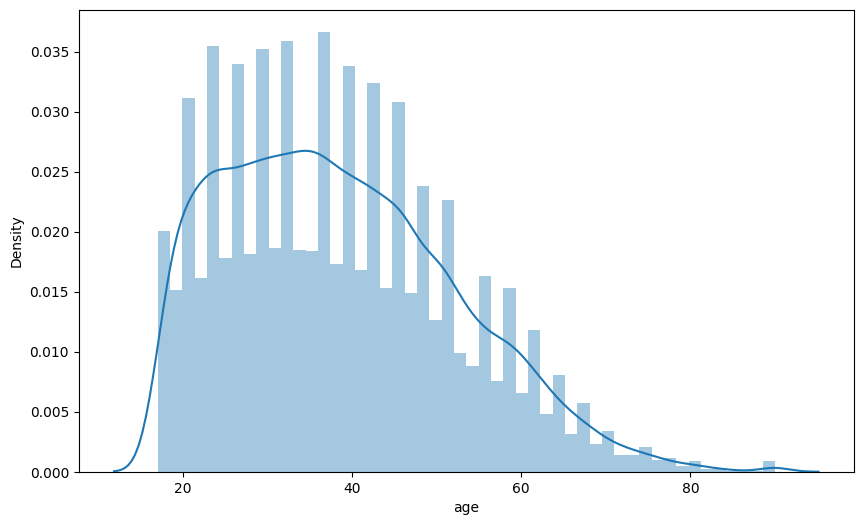

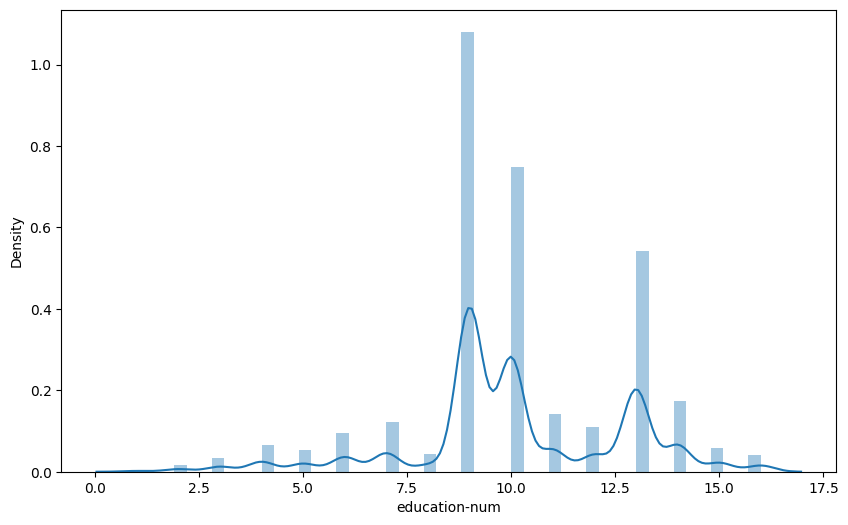

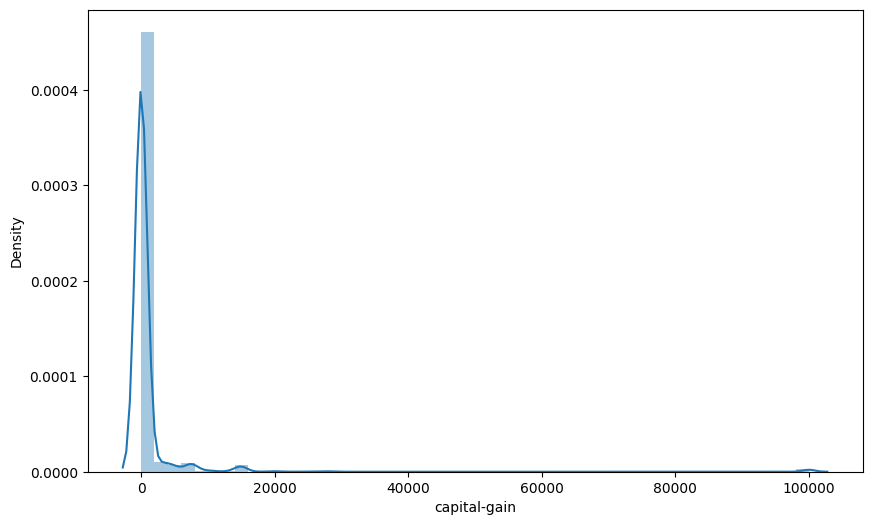

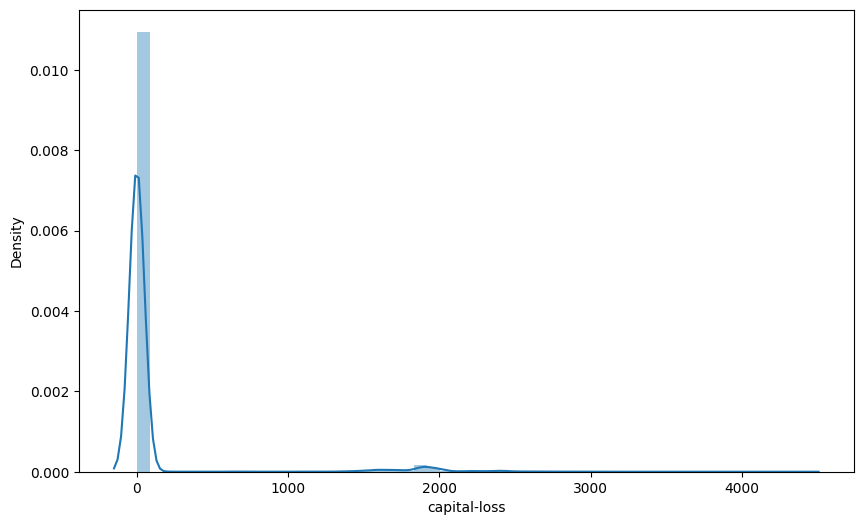

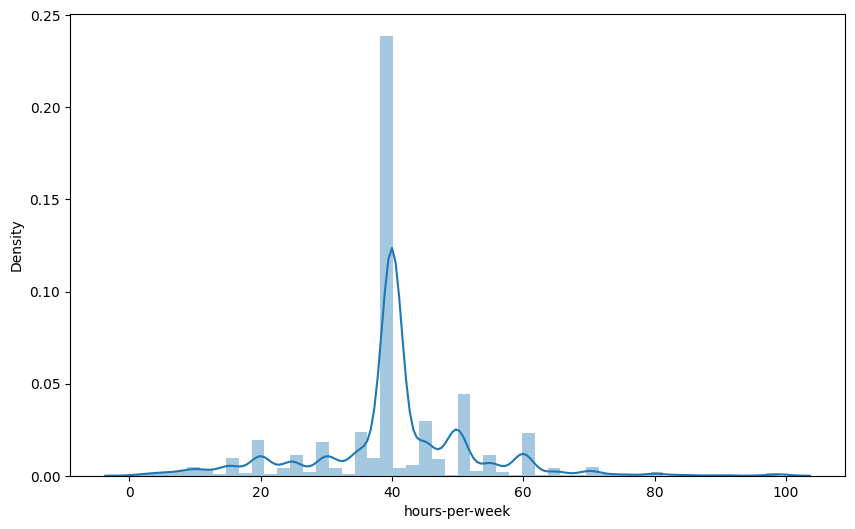

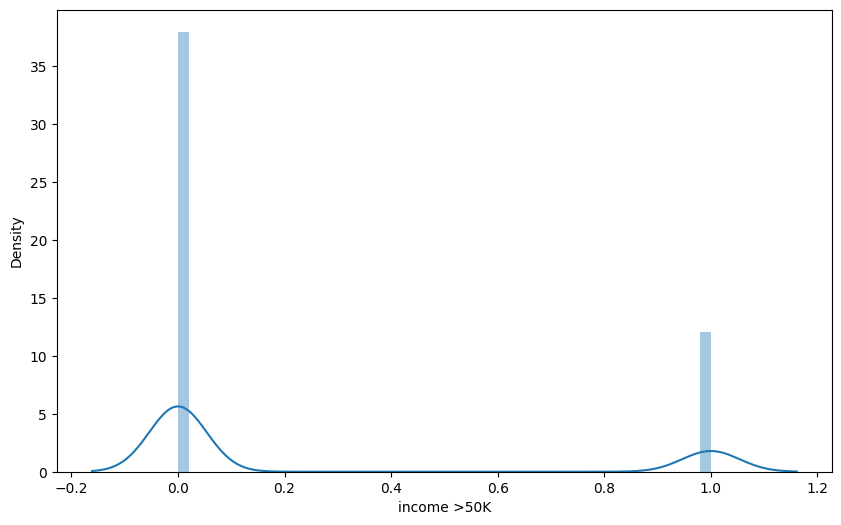

In [14]:
## Start with the continuous features
for col in continuous_features:
    plt.figure(figsize=(10, 6))
    sns.distplot(data[col])

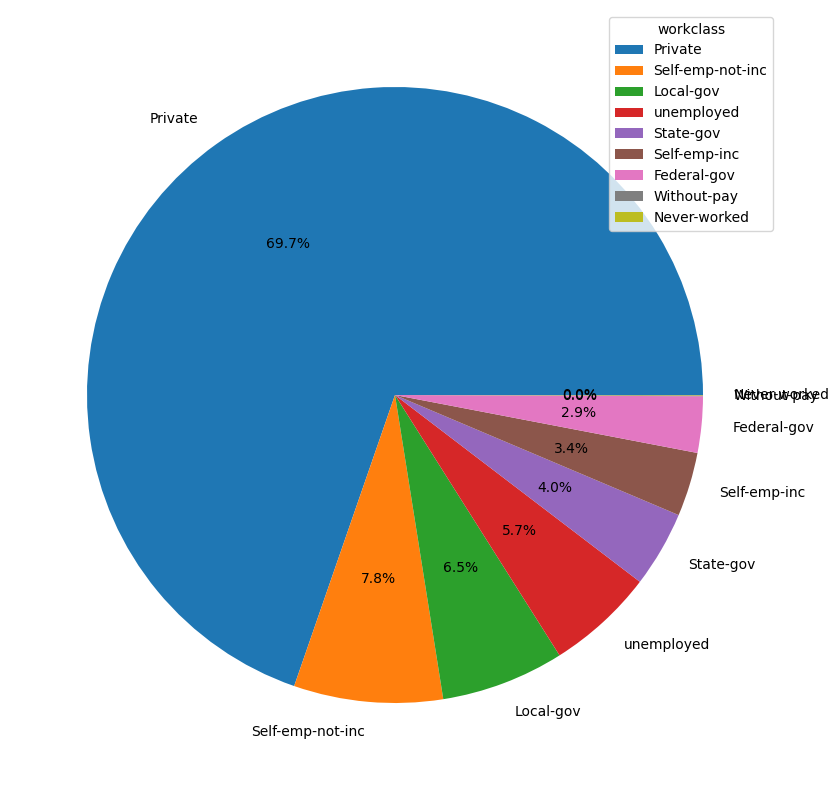

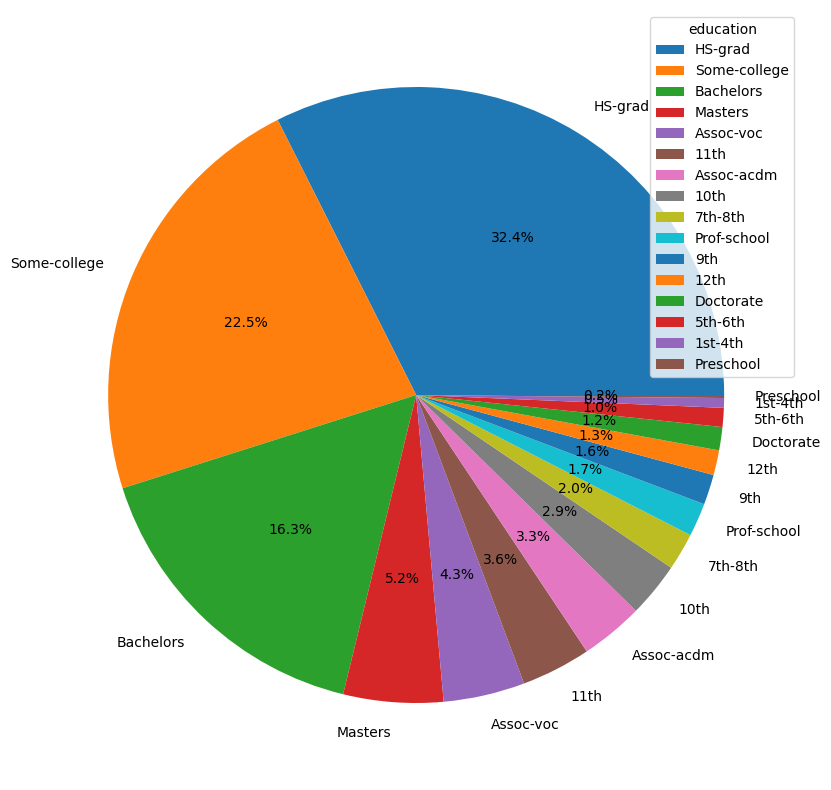

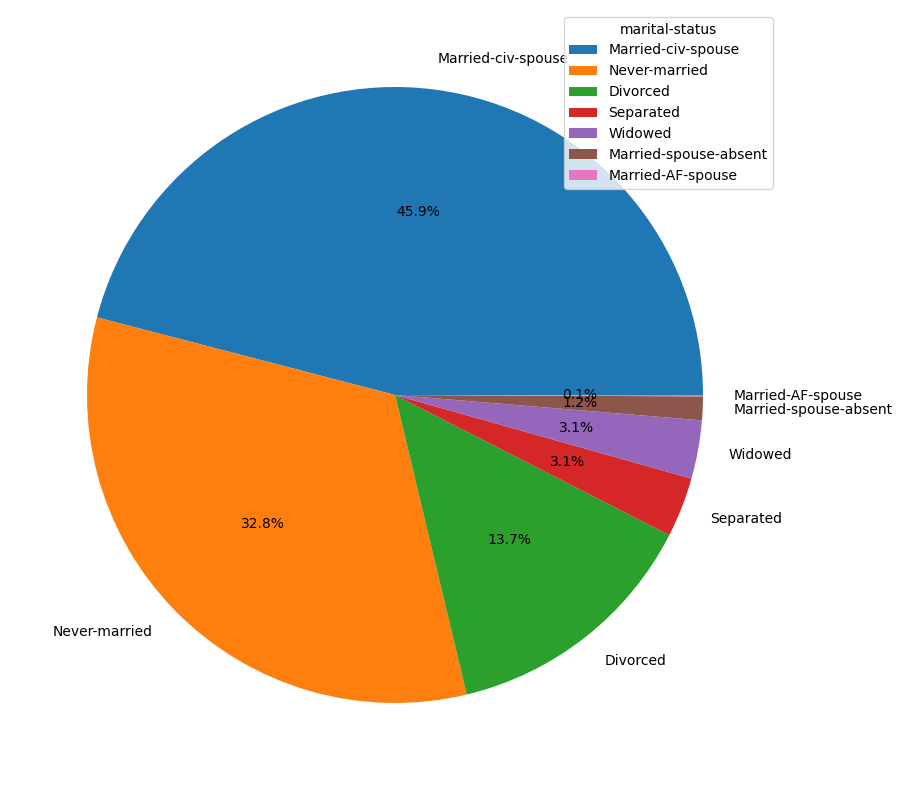

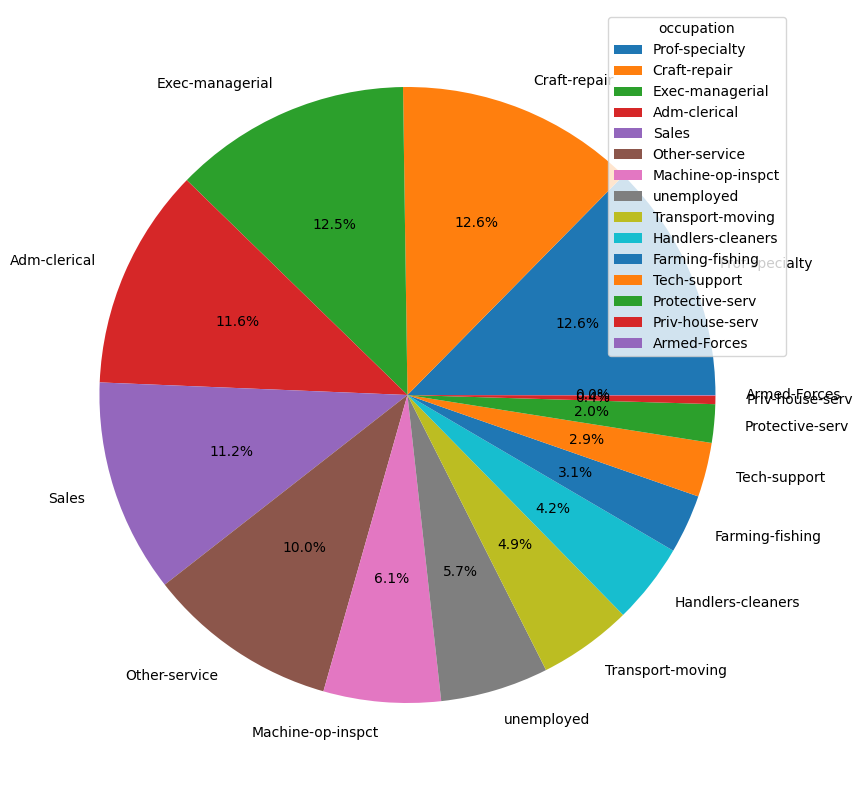

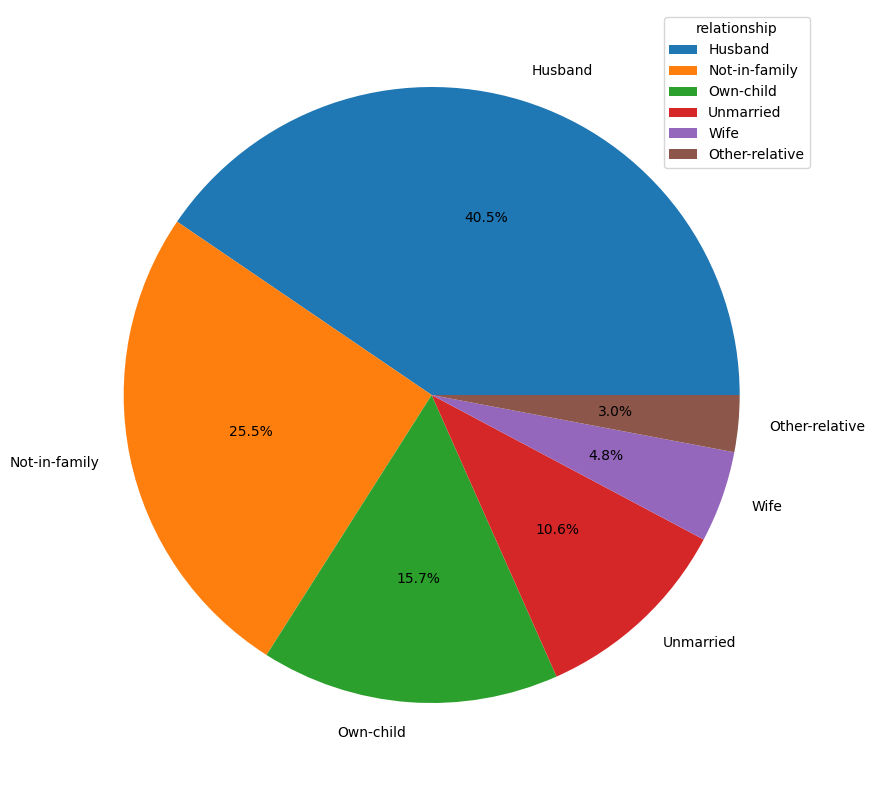

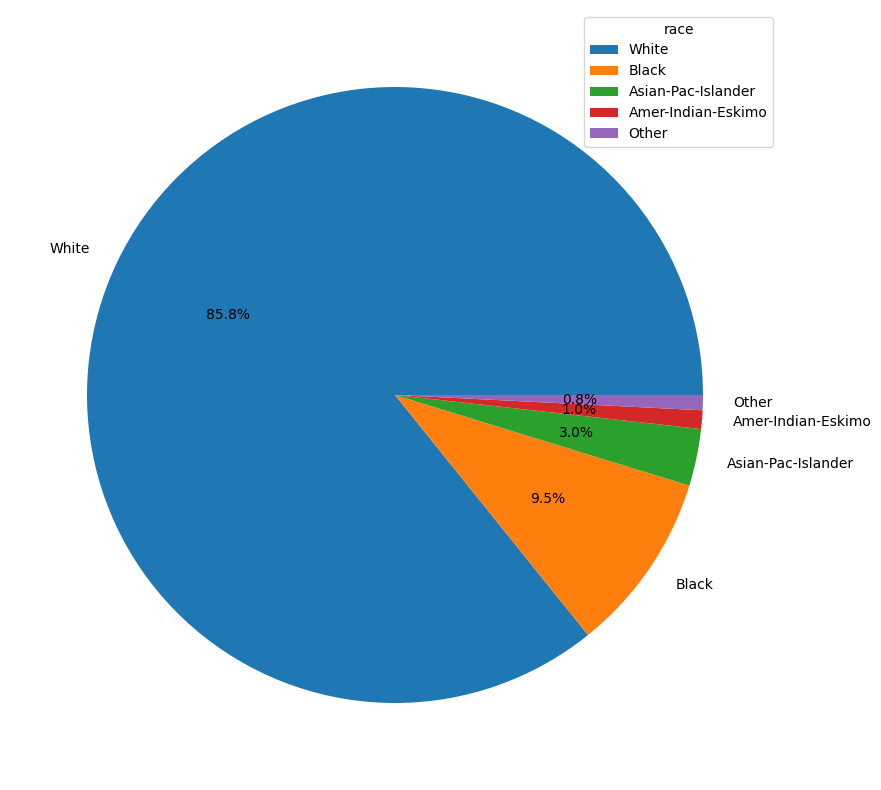

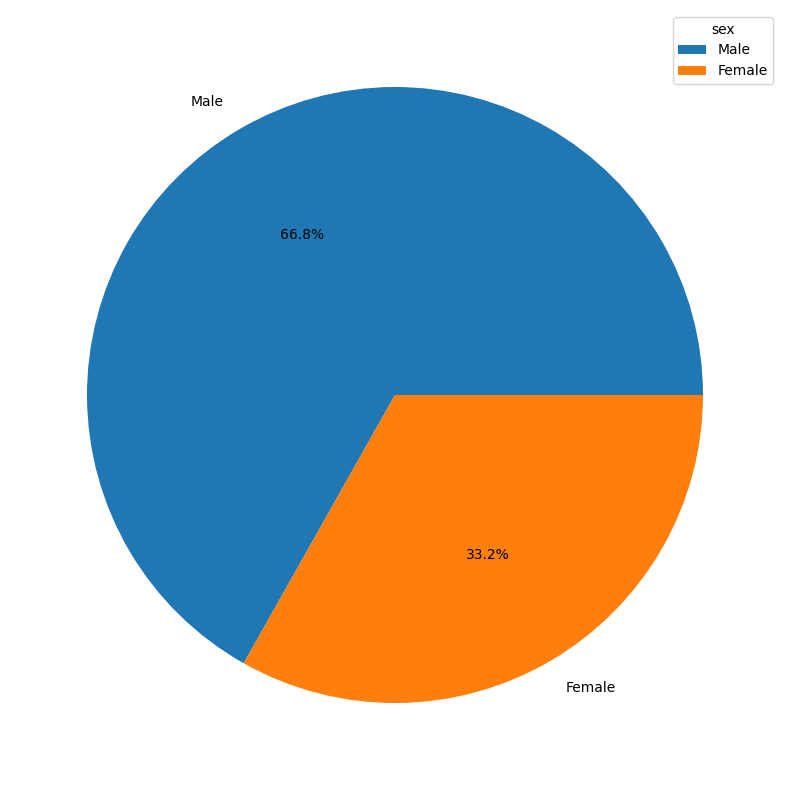

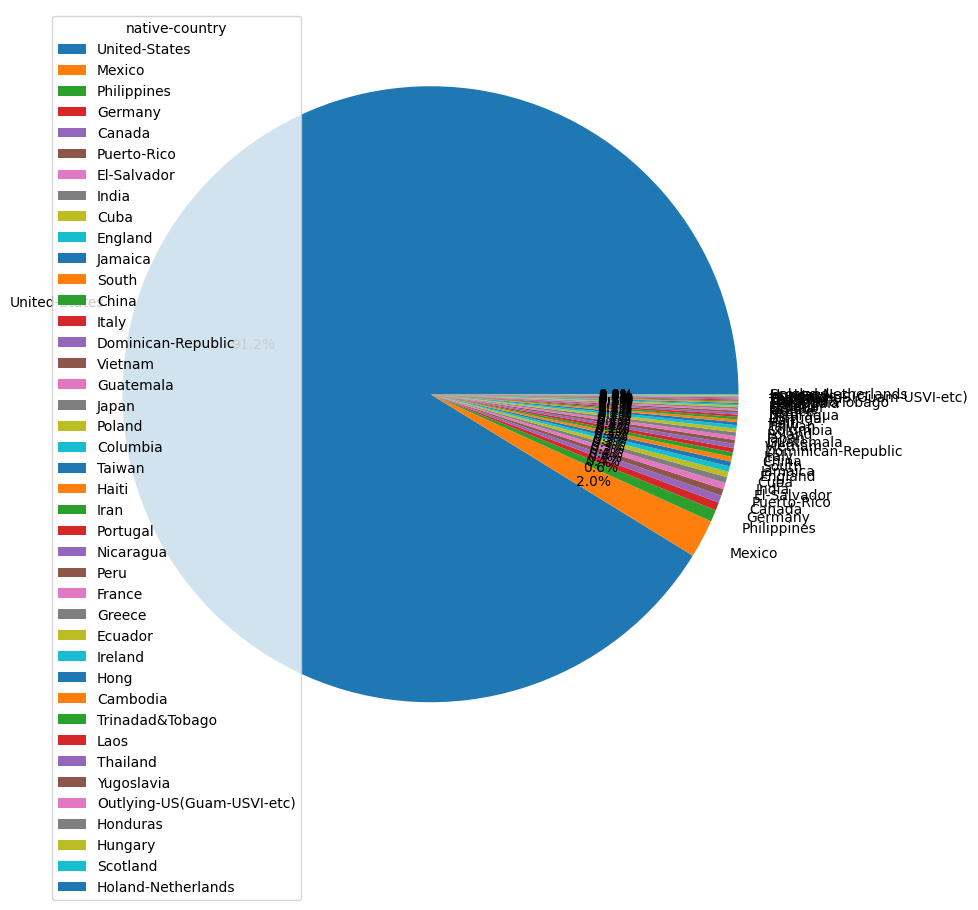

In [15]:
for col in discrete_features:
  plt.figure(figsize=(10,10))
  plt.pie(data[col].value_counts(), labels=data[col].value_counts().index, autopct='%1.1f%%')
  plt.legend(title = col)
  plt.show()

These distributions make a good amount of sense and teach us more about where this dataset was taken and the type of people it contains

### To Summarize
This data was most likely taken in the United-States by a largely white male population working mostly in the private sector. The average age is around 30 years old and more make less then 50k a year. 

We notice in our distribution graphs that our target class is heavily weighted, with a much larger density of people with an income less then or equal to 50k a year. This will be important to keep in mind when we are training our models.

There are a total of 13 features: 5 discrete and 7 continuous. Some features are more correlated then others. For example, `education` and `education-num` are the same feature, the latter being just a numerical representation of the former. 

### 3. Brainstorm about the attributes (Feature Engineering)
*Think about the features that could be useful for this task, are they all present in the
dataset? Anything missing? Any attribute provided that doesn’t seem useful to you?*

For the most part we don't believe there to be any missing attributes as the features feel like a comprehensive list of what could be useful for this task. The one feature we think is missing is the location of the individual. This could be useful as some areas are wealthier then others and could therefore be a good indicator of an individual's income. 

The only attribute we believe not worth keeping is `education` as it is the same as `education-num` but encoded as a string. We will therefore drop this feature.

In [16]:
data.drop('education', axis=1, inplace=True)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31978 entries, 0 to 31977
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             31978 non-null  int64 
 1   workclass       31978 non-null  object
 2   education-num   31978 non-null  int64 
 3   marital-status  31978 non-null  object
 4   occupation      31978 non-null  object
 5   relationship    31978 non-null  object
 6   race            31978 non-null  object
 7   sex             31978 non-null  object
 8   capital-gain    31978 non-null  int64 
 9   capital-loss    31978 non-null  int64 
 10  hours-per-week  31978 non-null  int64 
 11  native-country  31978 non-null  object
 12  income >50K     31978 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 3.2+ MB


### 4. Encode the Features
*As you will use models that need discrete or continuous attributes, think about data encoding and transformation*

Looking at the distribution of our continuous features, we notice that for the most part they all follow a normal Gaussian distribution (the only exception being our target and `education-num`, which is basically a discrete feature). So for our Naive Bayes model, we feel comfortable using the data as is, simply scaling the continuous features using the `RobustScaler` and encoding our discrete values using the `LabelEncoder`.

However for our Logistic Regression and Multi-Layer Perceptron, we will need to transform our discrete values into one-hot encoded vectors. We will also need to normalize our continuous features.

#### 4.1 Processing the data for Naïve Bayes


Starting with our discrete features, we will use the robust scaler to normalize our continuous features.

In [18]:
nb_X = data.drop('income >50K', axis=1)
nb_X.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,66,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [19]:
from sklearn.preprocessing import RobustScaler
## Separate the discrete and continuous features
discrete_features = [v for v in nb_X.columns if nb_X[v].dtype == 'object']
continuous_features = [v for v in nb_X.columns if nb_X[v].dtype != 'object']

## Scale the continuous features
scaler = RobustScaler()

nb_X[continuous_features] = scaler.fit_transform(nb_X[continuous_features])
nb_X.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,1.45,State-gov,1.000000,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,0.0,United-States
1,0.65,Self-emp-not-inc,1.000000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,-5.4,United-States
2,0.05,Private,-0.333333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,0.0,United-States
3,0.80,Private,-1.000000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,0.0,United-States
4,-0.45,Private,1.000000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,0.0,Cuba


We will also encode our discrete features using the label encoder.

In [20]:
# ## Encode the discrete features using label encoding
# le = LabelEncoder()
# for col in nb_discrete_features:
#     nb_X[col] = le.fit_transform(nb_X[col])

# nb_X.head()

We will also encode our discrete features using one hot encoding.

In [21]:
enc = OneHotEncoder()

enc_feat = enc.fit_transform(nb_X[discrete_features]).toarray()
enc_feat = pd.DataFrame(enc_feat, columns=np.hstack(enc.categories_))
enc_feat.head()

nb_X = pd.concat([nb_X[continuous_features], enc_feat], axis=1)
nb_X.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,...,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
0,1.45,1.000000,2174.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.65,1.000000,0.0,0.0,-5.4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.05,-0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.80,-1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.45,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next we will encode our target class to strings to make it easier to read

In [22]:
nb_y = data['income >50K']
nb_y.head()

0    0
1    0
2    0
3    0
4    0
Name: income >50K, dtype: int64

In [23]:
nb_y.map({0: '<=50K', 1: '>50K'})

0        <=50K
1        <=50K
2        <=50K
3        <=50K
4        <=50K
         ...  
31973    <=50K
31974     >50K
31975    <=50K
31976    <=50K
31977     >50K
Name: income >50K, Length: 31978, dtype: object

#### 4.2 Encoding the data for Logistic Regression and Multi-Layer Perceptron
For our LR and MLP models, we will encode our features using one-hot encoding. We will also normalize our features.

In [24]:
lr_X = data.drop('income >50K', axis=1)
lr_X.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,66,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [25]:
## Encode the discrete features using one hot encoding
enc = OneHotEncoder()

enc_feat = enc.fit_transform(lr_X[discrete_features]).toarray()
enc_feat = pd.DataFrame(enc_feat, columns=np.hstack(enc.categories_))
enc_feat.head()

lr_X = pd.concat([lr_X[continuous_features], enc_feat], axis=1)
lr_X.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,...,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
0,66,13,2174,0,40,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,50,13,0,0,13,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,38,9,0,0,40,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,53,7,0,0,40,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,28,13,0,0,40,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
## Normalize the continuous features
from sklearn.preprocessing import normalize

lr_X[continuous_features] = normalize(lr_X[continuous_features], norm='l2')
lr_X.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,...,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
0,0.030339,0.005976,0.999353,0.0,0.018387,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.938564,0.244027,0.000000,0.0,0.244027,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.679765,0.160997,0.000000,0.0,0.715542,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.793790,0.104840,0.000000,0.0,0.599087,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.554157,0.257287,0.000000,0.0,0.791652,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Like our Naive Bayes model, we will encode our target class to strings to make it easier to read.

In [27]:
lr_y = data['income >50K']
lr_y.map({0: '<=50K', 1: '>50K'})

0        <=50K
1        <=50K
2        <=50K
3        <=50K
4        <=50K
         ...  
31973    <=50K
31974     >50K
31975    <=50K
31976    <=50K
31977     >50K
Name: income >50K, Length: 31978, dtype: object

#### 4.3 Multi-Layer Perceptron
Our Multi-Layer Perceptron can use the same data as our Logistic Regression model.

In [28]:
mlp_X = lr_X
mlp_y = lr_y

### 5. Prepare your data for the experiment using cross-validation

In [29]:
nb_X_train, nb_X_test, nb_y_train, nb_y_test = train_test_split(nb_X, nb_y, test_size=0.3, random_state=23)
lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(lr_X, lr_y, test_size=0.3, random_state=23)
mlp_X_train, mlp_X_test, mlp_y_train, mlp_y_test = train_test_split(mlp_X, mlp_y, test_size=0.3, random_state=23)

### 6. Training models

#### 6.1 Naïve Bayes

In [30]:
gnb = GaussianNB()

gnb.fit(nb_X_train, nb_y_train)

nb_y_pred = gnb.predict(nb_X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(nb_y_test, nb_y_pred)))

Model accuracy score: 0.7851


#### 6.2 Logistic Regression

In [31]:
# Training the model using logistic regression
lr = LogisticRegression(solver='liblinear') # using liblinear instead of default 'lbfgs' solver due to dataset size
lr.fit(lr_X_train, lr_y_train)

lr_y_pred = lr.predict(lr_X_test)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(lr_y_test, lr_y_pred)))

Model accuracy score: 0.8354


#### 6.3 Multi-Layer Perceptron

In [32]:
# Training the model using default parameters
# Default: hidden_layer_sizes=(100,)
mlp = MLPClassifier(max_iter=1000) ## Max iterations set to 1000 to avoid convergence warning
mlp.fit(mlp_X_train, mlp_y_train)

mlp_y_pred = mlp.predict(mlp_X_test)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(mlp_y_test, mlp_y_pred)))

Model accuracy score: 0.8305


### 7. Test your models using cross-validation (provided the splits in step 5)

#### 7.1 Naïve Bayes

In [33]:
nb_scores = cross_val_score(gnb, nb_X_train, nb_y_train, cv=10, scoring='accuracy')

print('Cross-validation scores:')
for i in range(10):
    print('Fold {}: {:.4f}'.format(i+1, nb_scores[i]))

print('Average cross-validation score: {:.4f}'.format(nb_scores.mean()))

Cross-validation scores:
Fold 1: 0.7798
Fold 2: 0.7816
Fold 3: 0.7780
Fold 4: 0.7736
Fold 5: 0.7895
Fold 6: 0.7793
Fold 7: 0.7793
Fold 8: 0.7770
Fold 9: 0.7784
Fold 10: 0.7828
Average cross-validation score: 0.7799


#### 7.2 Logistic Regression

In [34]:
lr_scores = cross_val_score(lr, lr_X_train, lr_y_train, cv=10, scoring='accuracy')

print('Cross-validation scores:')
for i in range(10):
    print('Fold {}: {:.4f}'.format(i+1, lr_scores[i]))

print('Average cross-validation score: {:.4f}'.format(lr_scores.mean()))

Cross-validation scores:
Fold 1: 0.8321
Fold 2: 0.8254
Fold 3: 0.8334
Fold 4: 0.8169
Fold 5: 0.8356
Fold 6: 0.8324
Fold 7: 0.8320
Fold 8: 0.8239
Fold 9: 0.8302
Fold 10: 0.8123
Average cross-validation score: 0.8274


#### 7.3 Multi-Layer Perceptron

In [35]:
mlp_scores = cross_val_score(mlp, mlp_X_train, mlp_y_train, cv=10, scoring='accuracy')

print('Cross-validation scores:')
for i in range(10):
    print('Fold {}: {:.4f}'.format(i+1, mlp_scores[i]))

print('Average cross-validation score: {:.4f}'.format(mlp_scores.mean()))

Cross-validation scores:
Fold 1: 0.8321
Fold 2: 0.8133
Fold 3: 0.8356
Fold 4: 0.8169
Fold 5: 0.8208
Fold 6: 0.8172
Fold 7: 0.8208
Fold 8: 0.8342
Fold 9: 0.8342
Fold 10: 0.8271
Average cross-validation score: 0.8252


### Summary of Results

### 8. Perform an evaluation with precision/recall measures

#### a) Naïve Bayes

##### Confusion Matrix

True Negative: 5597
True Positive: 1935
False Negative: 1656
False Positive: 406


<AxesSubplot: >

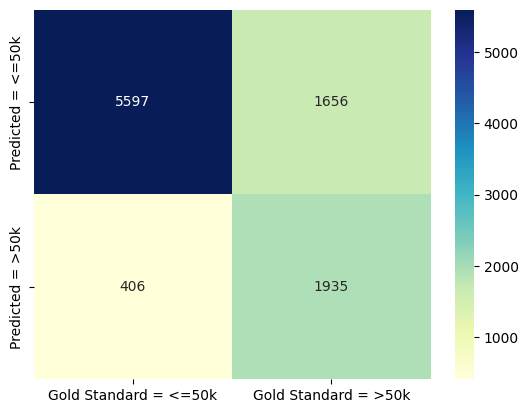

In [36]:
nb_matrix = confusion_matrix(nb_y_test, nb_y_pred)

nb_matrixDf = pd.DataFrame(data=nb_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', nb_matrix[0,0])
print('True Positive:', nb_matrix[1,1])
print('False Negative:', nb_matrix[0,1])
print('False Positive:', nb_matrix[1,0])

sns.heatmap(nb_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

##### Classification Report

In [37]:
nb_report = classification_report(nb_y_test, nb_y_pred, target_names=['<=50k', '>50k'])
print(nb_report)

              precision    recall  f1-score   support

       <=50k       0.93      0.77      0.84      7253
        >50k       0.54      0.83      0.65      2341

    accuracy                           0.79      9594
   macro avg       0.74      0.80      0.75      9594
weighted avg       0.84      0.79      0.80      9594



##### Summary of results
We notice very quickly that while our model is very precise when it comes to guessing if a person makes less then 50k a year, it is very bad at guessing if a person makes more then 50k a year. We can see this in the precision score of 0.54 for the positive class. 

#### b) Logistic Regression

True Negative: 6679
True Positive: 1336
False Negative: 574
False Positive: 1005


<AxesSubplot: >

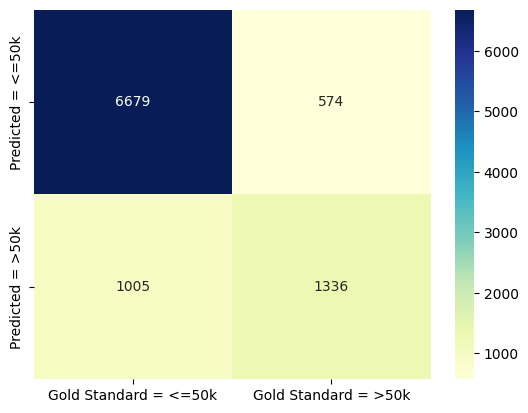

In [38]:
lr_matrix = confusion_matrix(lr_y_test, lr_y_pred)

lr_matrixDf = pd.DataFrame(data=lr_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', lr_matrix[0,0])
print('True Positive:', lr_matrix[1,1])
print('False Negative:', lr_matrix[0,1])
print('False Positive:', lr_matrix[1,0])

sns.heatmap(lr_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [39]:
lr_report = classification_report(lr_y_test, lr_y_pred, target_names=['<=50k', '>50k'])
print(lr_report)

              precision    recall  f1-score   support

       <=50k       0.87      0.92      0.89      7253
        >50k       0.70      0.57      0.63      2341

    accuracy                           0.84      9594
   macro avg       0.78      0.75      0.76      9594
weighted avg       0.83      0.84      0.83      9594



##### Summary of Results
Unlike our Naive Bayes model, our Logistic Regression model is much more precise when it comes to guessing if a person makes more then 50k a year. However, it's recall score is much lower then our Naive Bayes model. The model overall seems much more hesitant to say an individual makes more then 50k a year when compared to Naive Bayes

#### c) Multi-Layer Perceptron

True Negative: 6574
True Positive: 1394
False Negative: 679
False Positive: 947


<AxesSubplot: >

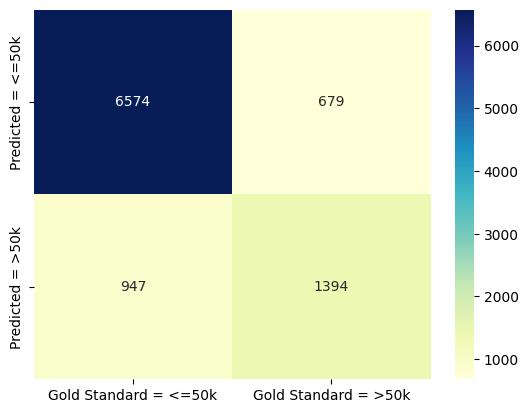

In [40]:
mlp_matrix = confusion_matrix(mlp_y_test, mlp_y_pred)

mlp_matrixDf = pd.DataFrame(data=mlp_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', mlp_matrix[0,0])
print('True Positive:', mlp_matrix[1,1])
print('False Negative:', mlp_matrix[0,1])
print('False Positive:', mlp_matrix[1,0])

sns.heatmap(mlp_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [41]:
mlp_report = classification_report(mlp_y_test, mlp_y_pred, target_names=['<=50k', '>50k'])
print(mlp_report)

              precision    recall  f1-score   support

       <=50k       0.87      0.91      0.89      7253
        >50k       0.67      0.60      0.63      2341

    accuracy                           0.83      9594
   macro avg       0.77      0.75      0.76      9594
weighted avg       0.82      0.83      0.83      9594



##### Summary of results
Again, our MLP model has a better precision score for the positive class then our Naive Bayes model while having a much lower recall score.

### 9. For each type of model, modify some parameters and perform a train/test/evaluate again. Do this twice for each model. 

#### 9.1 Naïve Bayes

##### Run 2
GuassianNB only has two parameters, `var_smoothing` and `priors`. We will only modify `var_smoothing`

Training the model

In [42]:
# Default var smoothing is 1e-9, we will try 1e-11 to see it's effects (if any)
gnb_2 = GaussianNB(var_smoothing=1e-11)

gnb_2.fit(nb_X_train, nb_y_train)

nb_y_pred_2 = gnb_2.predict(nb_X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(nb_y_test, nb_y_pred_2)))

Model accuracy score: 0.7348


Test using cross-validation

In [43]:
nb2_scores = cross_val_score(gnb_2, nb_X_train, nb_y_train, cv=10, scoring='accuracy')

print('Cross-validation scores:')
for i in range(10):
    print('Fold {}: {:.4f}'.format(i+1, nb2_scores[i]))

print('Average cross-validation score: {:.4f}'.format(nb2_scores.mean()))

Cross-validation scores:
Fold 1: 0.7222
Fold 2: 0.7195
Fold 3: 0.7343
Fold 4: 0.7213
Fold 5: 0.7391
Fold 6: 0.7256
Fold 7: 0.7297
Fold 8: 0.7274
Fold 9: 0.7234
Fold 10: 0.7332
Average cross-validation score: 0.7276


Evaluation

True Negative: 5597
True Positive: 1935
False Negative: 1656
False Positive: 406


<AxesSubplot: >

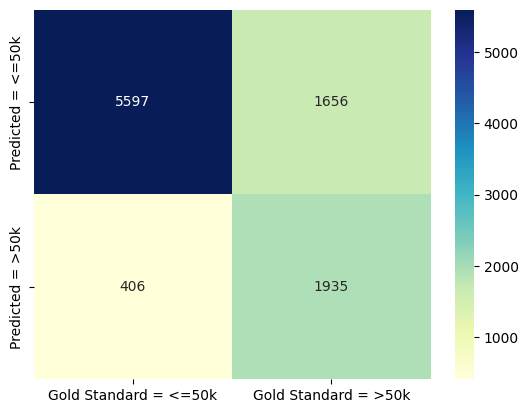

In [44]:
# Confusion Matrix
nb2_matrix = confusion_matrix(nb_y_test, nb_y_pred)

nb2_matrixDf = pd.DataFrame(data=nb2_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', nb2_matrix[0,0])
print('True Positive:', nb2_matrix[1,1])
print('False Negative:', nb2_matrix[0,1])
print('False Positive:', nb2_matrix[1,0])

sns.heatmap(nb2_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [45]:
# Classification Report
nb2_report = classification_report(nb_y_test, nb_y_pred_2, target_names=['<=50k', '>50k'])
print(nb2_report)

              precision    recall  f1-score   support

       <=50k       0.95      0.69      0.80      7253
        >50k       0.48      0.88      0.62      2341

    accuracy                           0.73      9594
   macro avg       0.71      0.78      0.71      9594
weighted avg       0.83      0.73      0.75      9594



##### Run 3

Training the model

In [46]:
## This time we will try increasing our var_smoothing to 1e-7
gnb_3 = GaussianNB(var_smoothing=1e-7)

gnb_3.fit(nb_X_train, nb_y_train)

nb_y_pred_3 = gnb_3.predict(nb_X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(nb_y_test, nb_y_pred_3)))

Model accuracy score: 0.7985


Test using cross-validation

In [47]:
nb3_scores = cross_val_score(gnb_3, nb_X_train, nb_y_train, cv=10, scoring='accuracy')

print('Cross-validation scores:')
for i in range(10):
    print('Fold {}: {:.4f}'.format(i+1, nb3_scores[i]))


print('Average cross-validation score: {:.4f}'.format(nb3_scores.mean()))

Cross-validation scores:
Fold 1: 0.7977
Fold 2: 0.7990
Fold 3: 0.7932
Fold 4: 0.7896
Fold 5: 0.7954
Fold 6: 0.7936
Fold 7: 0.7936
Fold 8: 0.7851
Fold 9: 0.7994
Fold 10: 0.7909
Average cross-validation score: 0.7937


Evaluation

True Negative: 6929
True Positive: 732
False Negative: 324
False Positive: 1609


<AxesSubplot: >

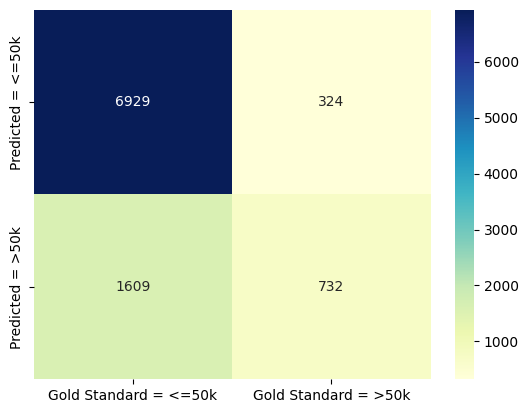

In [48]:
# Confusion Matrix
nb3_matrix = confusion_matrix(nb_y_test, nb_y_pred_3)

nb3_matrixDf = pd.DataFrame(data=nb3_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', nb3_matrix[0,0])
print('True Positive:', nb3_matrix[1,1])
print('False Negative:', nb3_matrix[0,1])
print('False Positive:', nb3_matrix[1,0])

sns.heatmap(nb3_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [49]:
# Classification Report
nb3_report = classification_report(nb_y_test, nb_y_pred_3, target_names=['<=50k', '>50k'])
print(nb3_report)

              precision    recall  f1-score   support

       <=50k       0.81      0.96      0.88      7253
        >50k       0.69      0.31      0.43      2341

    accuracy                           0.80      9594
   macro avg       0.75      0.63      0.65      9594
weighted avg       0.78      0.80      0.77      9594



##### Summary of results  

For our second run, we decreased our variable smoothing and noticed that our accuracy went down by a significant amount (from 0.77 to 0.72). We also notice in our classification report that our precision score for the positive class went down by a significant amount (from 0.54 to 0.48). This shows that increasing the variable smoothing decreases the precision of our model.

For our third run, we did the opposite. The accuracy of our model doesn't seem to have been significantly affected (from 0.77 to 0.79). However we see in our classification report that our recall score for the positive class went down by a very large amount (from 0.83 to 0.31). 

#### 9.2 Logistic Regression

##### Run 2
For our second run, we will try to change our penalty from 'l2' to 'l1'.

Training the model

In [50]:
lr_2 = LogisticRegression(solver='liblinear', penalty='l1')
lr_2.fit(lr_X_train, lr_y_train)

lr_y_pred_2 = lr_2.predict(lr_X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(lr_y_test, lr_y_pred_2)))

Model accuracy score: 0.8368


Test using cross-validation

In [51]:
lr2_scores = cross_val_score(lr_2, lr_X_train, lr_y_train, cv=10, scoring='accuracy')

print('Cross-validation scores:')
for i in range(10):
    print('Fold {}: {:.4f}'.format(i+1, lr2_scores[i]))

print('Average cross-validation score: {:.4f}'.format(lr2_scores.mean()))

Cross-validation scores:
Fold 1: 0.8321
Fold 2: 0.8254
Fold 3: 0.8339
Fold 4: 0.8182
Fold 5: 0.8365
Fold 6: 0.8311
Fold 7: 0.8311
Fold 8: 0.8244
Fold 9: 0.8329
Fold 10: 0.8132
Average cross-validation score: 0.8279


Evaluation

True Negative: 6683
True Positive: 1345
False Negative: 570
False Positive: 996


<AxesSubplot: >

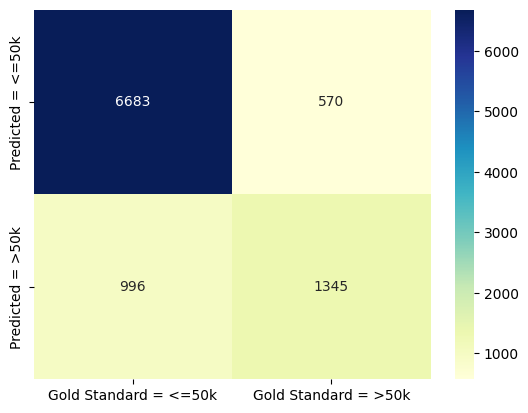

In [52]:
# Confusion Matrix
lr2_matrix = confusion_matrix(lr_y_test, lr_y_pred_2)

lr2_matrixDf = pd.DataFrame(data=lr2_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', lr2_matrix[0,0])
print('True Positive:', lr2_matrix[1,1])
print('False Negative:', lr2_matrix[0,1])
print('False Positive:', lr2_matrix[1,0])

sns.heatmap(lr2_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [53]:
# Classification Report
lr2_report = classification_report(lr_y_test, lr_y_pred_2, target_names=['<=50k', '>50k'])
print(lr2_report)

              precision    recall  f1-score   support

       <=50k       0.87      0.92      0.90      7253
        >50k       0.70      0.57      0.63      2341

    accuracy                           0.84      9594
   macro avg       0.79      0.75      0.76      9594
weighted avg       0.83      0.84      0.83      9594



##### Run 3

For this run, we will add inverse regularization by setting `C` to 0.2 from 1. Making C smaller increases the regularization strength.

Trainning the model

In [54]:
lr_3 = LogisticRegression(solver='liblinear', C=0.2)
lr_3.fit(lr_X_train, lr_y_train)

lr_y_pred_3 = lr_3.predict(lr_X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(lr_y_test, lr_y_pred_3)))

Model accuracy score: 0.8352


Test using cross-validation

In [55]:
lr3_scores = cross_val_score(
    lr_3, lr_X_train, lr_y_train, cv=10, scoring='accuracy')

print('Cross-validation scores:')
for i in range(10):
    print('Fold {}: {:.4f}'.format(i+1, lr3_scores[i]))

print('Average cross-validation score: {:.4f}'.format(lr3_scores.mean()))


Cross-validation scores:
Fold 1: 0.8330
Fold 2: 0.8249
Fold 3: 0.8330
Fold 4: 0.8164
Fold 5: 0.8347
Fold 6: 0.8338
Fold 7: 0.8315
Fold 8: 0.8235
Fold 9: 0.8271
Fold 10: 0.8132
Average cross-validation score: 0.8271


Evaluation

True Negative: 6688
True Positive: 1325
False Negative: 565
False Positive: 1016


<AxesSubplot: >

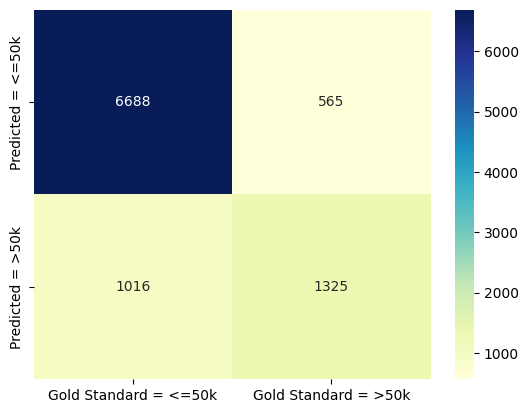

In [56]:
# Confusion Matrix
lr3_matrix = confusion_matrix(lr_y_test, lr_y_pred_3)

lr3_matrixDf = pd.DataFrame(data=lr3_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', lr3_matrix[0,0])
print('True Positive:', lr3_matrix[1,1])
print('False Negative:', lr3_matrix[0,1])
print('False Positive:', lr3_matrix[1,0])

sns.heatmap(lr3_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [57]:
# Classification Report
lr3_report = classification_report(lr_y_test, lr_y_pred_3, target_names=['<=50k', '>50k'])
print(lr3_report)

              precision    recall  f1-score   support

       <=50k       0.87      0.92      0.89      7253
        >50k       0.70      0.57      0.63      2341

    accuracy                           0.84      9594
   macro avg       0.78      0.74      0.76      9594
weighted avg       0.83      0.84      0.83      9594



##### Summary of results
Interestingly, our classification reports show that our logistic regression had little to no changes regardless of the settings we changed.

#### 9.3 Multi-Layer Perceptron

##### Run 2

For our second Multi-layer perceptron, we will try to increase the number of hidden layers.

Training the model

In [58]:
mlp_2 = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000) # 2 hidden layers with 100 neurons each, 1000 iterations to avoid convergence warning
mlp_2.fit(mlp_X_train, mlp_y_train)

mlp_y_pred_2 = mlp_2.predict(mlp_X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(mlp_y_test, mlp_y_pred_2)))

Model accuracy score: 0.8222


Test using cross-validation

In [59]:
mlp3_scores = cross_val_score(mlp_2, mlp_X_train, mlp_y_train, cv=10)

print('Cross-validation scores:')
for i in range(10):
  print('Fold {}: {:.4f}'.format(i+1, mlp3_scores[i]))

print('Average cross-validation score: {:.4f}'.format(mlp3_scores.mean()))

Cross-validation scores:
Fold 1: 0.8285
Fold 2: 0.8106
Fold 3: 0.8249
Fold 4: 0.8133
Fold 5: 0.8155
Fold 6: 0.8199
Fold 7: 0.8146
Fold 8: 0.8262
Fold 9: 0.8315
Fold 10: 0.8208
Average cross-validation score: 0.8206


Evaluation

True Negative: 6500
True Positive: 1388
False Negative: 753
False Positive: 953


<AxesSubplot: >

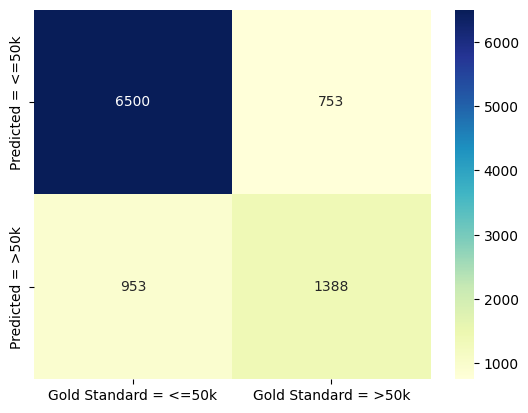

In [60]:
# Confusion Matrix
mlp3_matrix = confusion_matrix(mlp_y_test, mlp_y_pred_2)

mlp3_matrixDf = pd.DataFrame(data=mlp3_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', mlp3_matrix[0,0])
print('True Positive:', mlp3_matrix[1,1])
print('False Negative:', mlp3_matrix[0,1])
print('False Positive:', mlp3_matrix[1,0])

sns.heatmap(mlp3_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [61]:
# Classification Report
mlp2_report = classification_report(mlp_y_test, mlp_y_pred_2, target_names=['<=50k', '>50k'])
print(mlp2_report)

              precision    recall  f1-score   support

       <=50k       0.87      0.90      0.88      7253
        >50k       0.65      0.59      0.62      2341

    accuracy                           0.82      9594
   macro avg       0.76      0.74      0.75      9594
weighted avg       0.82      0.82      0.82      9594



##### Run 3

For our final run, we will try changing the number of neurons in our hidden layer.

Training the model

In [62]:
mlp_3 = MLPClassifier(hidden_layer_sizes=(200), max_iter=1000) # 1 hidden layer with 200 neurons, 1000 iterations to avoid convergence warning
mlp_3.fit(mlp_X_train, mlp_y_train)

mlp_y_pred_3 = mlp_3.predict(mlp_X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(mlp_y_test, mlp_y_pred_3)))

Model accuracy score: 0.8272


Test using cross-validation

In [63]:
mlp3_scores = cross_val_score(mlp_3, mlp_X_train, mlp_y_train, cv=10)

print('Cross-validation scores:')
for i in range(10):
  print('Fold {}: {:.4f}'.format(i+1, mlp3_scores[i]))

print('Average cross-validation score: {:.4f}'.format(mlp3_scores.mean()))

Cross-validation scores:
Fold 1: 0.8379
Fold 2: 0.8097
Fold 3: 0.8450
Fold 4: 0.8254
Fold 5: 0.8289
Fold 6: 0.8217
Fold 7: 0.8155
Fold 8: 0.8378
Fold 9: 0.8275
Fold 10: 0.8226
Average cross-validation score: 0.8272


Evaluation

True Negative: 6498
True Positive: 1438
False Negative: 755
False Positive: 903


<AxesSubplot: >

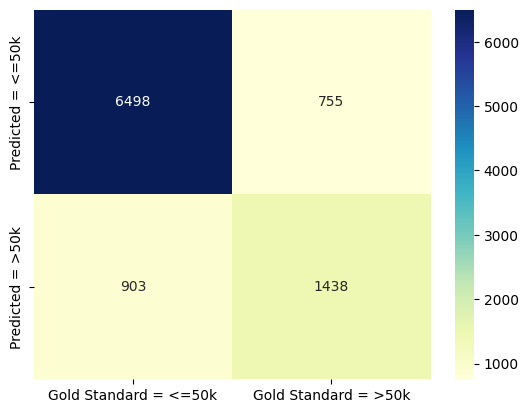

In [64]:
# Confusion Matrix
mlp3_matrix = confusion_matrix(mlp_y_test, mlp_y_pred_3)

mlp3_matrixDf = pd.DataFrame(data=mlp3_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', mlp3_matrix[0,0])
print('True Positive:', mlp3_matrix[1,1])
print('False Negative:', mlp3_matrix[0,1])
print('False Positive:', mlp3_matrix[1,0])

sns.heatmap(mlp3_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [65]:
# Classification Report
mlp3_report = classification_report(mlp_y_test, mlp_y_pred_3, target_names=['<=50k', '>50k'])
print(mlp3_report)

              precision    recall  f1-score   support

       <=50k       0.88      0.90      0.89      7253
        >50k       0.66      0.61      0.63      2341

    accuracy                           0.83      9594
   macro avg       0.77      0.76      0.76      9594
weighted avg       0.82      0.83      0.83      9594



#### Summary of results

### 10. Analyze the obtained results

##### a) *Compare quantitatively (with the precision/recall measures) your 9 results. The 9 results come from 3 models, each with default parameters from step 6 + 2 variations from step 9.*

Naive Bayes

In [66]:
# Print our NB classification reports
print('Run 1')
print(nb_report)

print('Run 2')
print(nb2_report)

print('Run 3')
print(nb3_report)

Run 1
              precision    recall  f1-score   support

       <=50k       0.93      0.77      0.84      7253
        >50k       0.54      0.83      0.65      2341

    accuracy                           0.79      9594
   macro avg       0.74      0.80      0.75      9594
weighted avg       0.84      0.79      0.80      9594

Run 2
              precision    recall  f1-score   support

       <=50k       0.95      0.69      0.80      7253
        >50k       0.48      0.88      0.62      2341

    accuracy                           0.73      9594
   macro avg       0.71      0.78      0.71      9594
weighted avg       0.83      0.73      0.75      9594

Run 3
              precision    recall  f1-score   support

       <=50k       0.81      0.96      0.88      7253
        >50k       0.69      0.31      0.43      2341

    accuracy                           0.80      9594
   macro avg       0.75      0.63      0.65      9594
weighted avg       0.78      0.80      0.77      9594



Logistic Regression

In [67]:
# Print our LR classification reports
print('Run 1')
print(lr_report)

print('Run 2')
print(lr2_report)

print('Run 3')
print(lr3_report)

Run 1
              precision    recall  f1-score   support

       <=50k       0.87      0.92      0.89      7253
        >50k       0.70      0.57      0.63      2341

    accuracy                           0.84      9594
   macro avg       0.78      0.75      0.76      9594
weighted avg       0.83      0.84      0.83      9594

Run 2
              precision    recall  f1-score   support

       <=50k       0.87      0.92      0.90      7253
        >50k       0.70      0.57      0.63      2341

    accuracy                           0.84      9594
   macro avg       0.79      0.75      0.76      9594
weighted avg       0.83      0.84      0.83      9594

Run 3
              precision    recall  f1-score   support

       <=50k       0.87      0.92      0.89      7253
        >50k       0.70      0.57      0.63      2341

    accuracy                           0.84      9594
   macro avg       0.78      0.74      0.76      9594
weighted avg       0.83      0.84      0.83      9594



Multi-Layer Perceptron

In [68]:
# Print our MLP classification reports
print('Run 1')
print(mlp_report)

print('Run 2')
print(mlp2_report)

print('Run 3')
print(mlp3_report)

Run 1
              precision    recall  f1-score   support

       <=50k       0.87      0.91      0.89      7253
        >50k       0.67      0.60      0.63      2341

    accuracy                           0.83      9594
   macro avg       0.77      0.75      0.76      9594
weighted avg       0.82      0.83      0.83      9594

Run 2
              precision    recall  f1-score   support

       <=50k       0.87      0.90      0.88      7253
        >50k       0.65      0.59      0.62      2341

    accuracy                           0.82      9594
   macro avg       0.76      0.74      0.75      9594
weighted avg       0.82      0.82      0.82      9594

Run 3
              precision    recall  f1-score   support

       <=50k       0.88      0.90      0.89      7253
        >50k       0.66      0.61      0.63      2341

    accuracy                           0.83      9594
   macro avg       0.77      0.76      0.76      9594
weighted avg       0.82      0.83      0.83      9594



- On average, Logistic Regression had the highest accuracy across of all our models. It also had the least variance between runs, with little to no changes to our classification report regardless of the parameters we changed.
- Logistic Regression saw little to no changes across our three runs, regardless of the parameters we changed
- Of the three models Logistic Regression had the best precision for the positive class, but Naive Bayes had the best precision for the negative class
- Of the three models, the second run of Naive Bayes achieved the highest recall for the positive class, but Logistic Regression had the highest recall for the negative class
